## Loading the libraries

In [26]:
import os
import spacy
import gensim
import gensim.downloader as api
import json
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
import statistics
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE

In [4]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

Initializing spacy with the english language and disabling the features `ner` & `parser` to save time, since they're not applicable

In [21]:
nlp = spacy.load("en_core_web_sm", disable = ["ner","parser"])

Below's code will deal with cleaning the dataframe that is put in as a parameter.

In [30]:
def cleaning(doc):
  txt = [token.lemma_.lower() for token in doc if not token.is_stop and len(token) > 1] # this line tokenizes, takes out stopwords, and returns lemmas. We also lowercase everything (works for english, not necessarily other langauges) and also only take words with more than one letter to get rid of punctuation. There's smarter ways to do that -- but this is meant to be simplistic!!
  if len(txt) > 2: # dump any sentences with less than 2 words -- word2vec is based on collocation, after all...
    return " ".join(txt)

def process(df):

  ## some things you should know about this function
  ## it takes in a pandas dataframe structured like that above
  ## you need to have a column titled "text" in your dataframe which has the full text of each document

  docs = [row for row in df["speech"]] # get your documents as a list of individual texts -- if you get a KeyError you might have to check your dataframe
  txts = [cleaning(doc) for doc in nlp.pipe(docs, batch_size=500)] # nlp.pipe is some spacy magic -- this is where the processing happens
  sentences = [row.split() for row in txts if row != None] # we need to return the cleaned data (from cleaning(doc)) as sentences for Gensim
  return sentences # this is what we pass to Gensim

Linking the dataset about british political speeches.  
This dataset has been cleaned to remove html code and only looks at the text in the speeches

In [31]:
os.path.normpath(os.getcwd() + os.sep + os.pardir)
df = pd.read_csv('Bias in British political Communication/data/Metadata.csv')

Tory_df = df.loc[df['party'] == 'Conservative']
tory_corpus = process(Tory_df)

Labour_df = df.loc[df['party'] == 'Labour']
labour_corpus = process(Labour_df)


In [32]:
len(tory_corpus)

118

In [33]:
len(labour_corpus)

123

Creating a Word2vec model for the conservative dataframe and training it.

In [34]:
## now that we've processed the texts with spacy, lets use Gensim to create a word2vec model

## first we initialize the model
from gensim.models import Word2Vec

model_tory = Word2Vec(
    min_count = 10, ## you can mess around with these parameters (don't mess with workers though!); min_count refers to words that appear at least N times 
    window = 4, ## window refers to the size of the window +/- N words for something to count as a collocation
    workers = 4 ## leave this one alone...refers to the number of CPUs/threads to use. This works with Google Colab so just leave it alone for now. 
)

model_tory.build_vocab(tory_corpus, progress_per = 50) # remember that sentences is just what we output after spacy did its work in the process(df) function

In [35]:
## now we train the model on our data

model_tory.train(tory_corpus, total_examples = model_tory.corpus_count, epochs = 30)

## This might take quite some time again

(5465567, 6709350)

Saves a word2vec file into the corresponding folder.

In [37]:
## cool. now we have a model. Now that you're refreshed from that nap, let's explore our model
## first, save the model

model_savename = "Bias in British political Communication//models/Tory.w2v"
model_tory.wv.save(model_savename)

Loading said Word2vec file.

In [38]:
## ok now the model is saved, so lets reload it
## we need to import a helper function from Gensim to reload the model

from gensim.models import KeyedVectors

model_tory = KeyedVectors.load(model_savename)

## it is always good practice to save and then reload your model after creating it. Also makes syntax easier later on due to pecularities with Gensim

In [46]:
## maybe you want a list of all the words in your model then?
## this is how you do that

print(model_tory.key_to_index);

{'people': 0, 'country': 1, 'government': 2, 'party': 3, 'year': 4, 'great': 5, 'work': 6, 'want': 7, 'know': 8, 'hear': 9, 'time': 10, 'britain': 11, 'world': 12, 'new': 13, 'go': 14, 'labour': 15, 'right': 16, 'think': 17, 'come': 18, 'good': 19, 'let': 20, 'need': 21, 'believe': 22, 'say': 23, 'way': 24, 'today': 25, 'british': 26, 'thing': 27, 'policy': 28, 'mean': 29, 'conservative': 30, 'change': 31, 'life': 32, 'child': 33, 'home': 34, 'man': 35, 'nation': 36, 'like': 37, 'school': 38, 'help': 39, 'long': 40, 'tell': 41, 'give': 42, 'mr.': 43, 'get': 44, 'power': 45, 'europe': 46, 'job': 47, 'look': 48, 'trade': 49, 'day': 50, 'national': 51, 'bring': 52, 'problem': 53, 'take': 54, 'free': 55, 'service': 56, 'cheers': 57, 'state': 58, 'future': 59, 'public': 60, 'family': 61, 'well': 62, 'pay': 63, 'course': 64, 'find': 65, 'house': 66, 'society': 67, 'interest': 68, 'shall': 69, 'responsibility': 70, 'election': 71, 'stand': 72, 'build': 73, 'conference': 74, 'week': 75, 'syste

Creating a frequency list from the words in the Conservative dataset.

In [43]:
## that's not super useful in itself
## let's make a table of our vocabulary with frequency

## set up a list to store our words + frequencies
records = list()

## iterate over every word in the vocab and get its frequency and save it to records
for word in model_tory.key_to_index:
  records.append((word, model_tory.key_to_index[word].count))

## make a table with some pandas magic
model_tory_vocab_df = pd.DataFrame.from_records(records, columns = ["lemma","frequency"])
model_tory_vocab_df.sort_values("frequency", ascending=False)

AttributeError: 'int' object has no attribute 'count'

Here I added the part-of-speech for each word.  
Not sure if something interesting can be done with it.  
Can also be removed

In [ ]:
def str_to_list(word):
  lst = []
  lst.append(word)
  return lst

In [ ]:
def get_pos(list_with_tuple):
  return [str(tup[1]) for tup in list_with_tuple]

In [ ]:
model_tory_vocab_df['POS'] = model_tory_vocab_df['lemma'].apply(str_to_list).apply(pos_tag)
model_tory_vocab_df['POS'] = model_tory_vocab_df['POS'].apply(get_pos)
model_tory_vocab_df['POS'] = model_tory_vocab_df['POS'].apply("".join)

In [ ]:
model_tory_vocab_df.loc[model_tory_vocab_df['POS'] == 'NN']

,lemma,frequency,POS
0,thank,175,NN
1,warm,14,NN
2,welcome,99,NN
3,excuse,33,NN
4,speech,241,NN
...,...,...,...
2709,calamity,14,NN
2710,lansdowne,14,NN
2711,nonconformist,14,NN
2712,cobden,21,NN


In [ ]:
len(model_tory_vocab_df)

2716

'Normal' code resumes again

In [ ]:
## NAIVE 2D Projection
## first I set up a function to do the plotting.

def naive_projection(x_axis, y_axis, test_words, model, plot_size=8):


  ## check if you have the right input data
  if len(x_axis) != 2:
    print("You must only have two antonyms in your x-axis")
  elif len(y_axis) !=2:
    print("You must only have two antonyms in your y-axis")
  else:

    ## lets do the projection

    x = list() # store x values for each test word
    y = list()

    ## now, we calculate the x and y coordinates for each of our test words
    for word in test_words:
      x_val = model.distance(x_axis[0], word) - model.distance(x_axis[1], word) # x_axis[0] is the first word of your antonym pair, x_axis[1] is the second word
      y_val = model.distance(y_axis[0], word) - model.distance(y_axis[1], word) # same thing, 0,1 here to select your antonyms
      x.append(x_val) # save x/y in our lists above
      y.append(y_val)
    
    ## now we plot the x/y values we just calculated

    fig, ax = plt.subplots(figsize=(plot_size,plot_size))

    for i in range(len(x)):
      ax.scatter(x[i], y[i])
      ax.annotate(test_words[i], (x[i], y[i]))
    
    xlab = x_axis[0] + " --- " + x_axis[1]
    ylab = y_axis[0] + " --- " + y_axis[1]
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.show()

Plotting the naive projection with `socialism` & `capitalism` on the x-axis  and `rich` & `poor` on the y-axis.

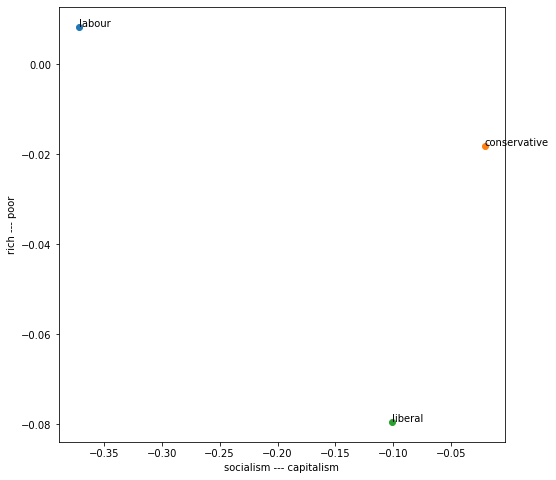

In [ ]:

x_axis = ["socialism","capitalism"]
y_axis = ["rich","poor"]
test_words = ["labour","conservative", "liberal"]

naive_projection(x_axis, y_axis, test_words, model_tory)

In [ ]:
##Creating an advanced projection

def advanced_projection(x_dimensions, y_dimensions, test_words, model, plot_size=6, xlab="label", ylab = "label"):
  x = list()
  y = list()

  ## measure each word against our composite axes, eg. "engineer"
  for word in test_words:

    ## set up some lists to hold our calculations
    x_vals = list()
    y_vals = list()

    ## this is a loop that calculates the x values for each individual dimension, eg man/woman, he/she
    for dim in x_dimensions:
      xval = model.distance(dim[0], word) - model.distance(dim[1], word)
      x_vals.append(xval)
    ## repeat for y values
    for dim in y_dimensions:
      yval = model.distance(dim[0], word) - model.distance(dim[1], word)
      y_vals.append(yval)

    ## ok now we need to take the average of all the x_vals and y_vals we collected for this word
    xavg = statistics.mean(x_vals)
    yavg = statistics.mean(y_vals)

    ## now lets save this to our x and y lists that we set up above (outside the for word in test_words loop) so that we can plot the word
    x.append(xavg)
    y.append(yavg)
  
  ## OK time to plot!
  fig, ax = plt.subplots(figsize=(plot_size,plot_size))

  for i in range(len(x)):
    ax.scatter(x[i], y[i])
    ax.annotate(test_words[i], (x[i], y[i]))

  plt.xlabel(xlab)
  plt.ylabel(ylab)

  plt.show()


Here, we plot the axes with more than just one pair of antonyms.

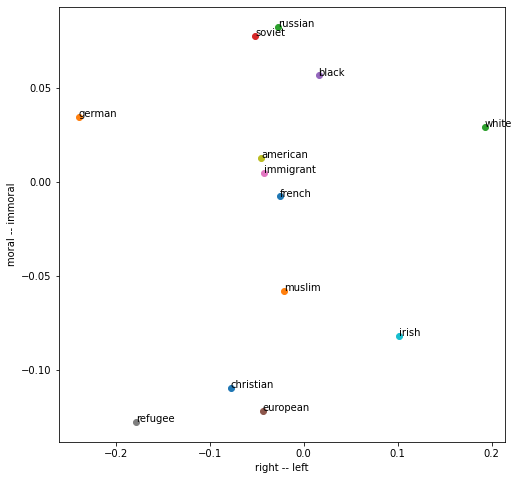

In [ ]:
x_dimensions = [
          ["conservative","progressive"],
          ["capitalist","socialist"],
          ["right","left"],
          
]

## remember -- check that these words actually exist in your vocab table -- a KeyError likely indicates one word or another is missing.

y_dimensions = [
                ["good","bad"],
                ["fair","unfair"],
                ["right", "wrong"],
                ["justice", "injustice"]
]

test_words = ["christian","muslim","white","soviet", "black","european", "immigrant","refugee","american","irish","french","german","russian"]

## scroll to the previous sections if you need a reminder on how to use the function
advanced_projection(
    x_dimensions,
    y_dimensions,
    test_words,
    model_tory,
    plot_size=8,
    xlab = "right -- left",
    ylab = "moral -- immoral"
)

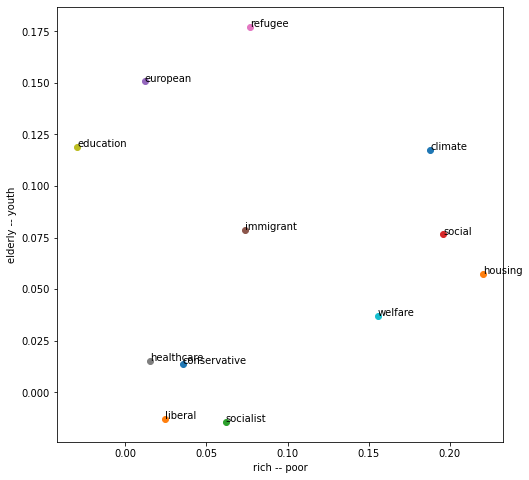

In [ ]:
x_dimensions = [
          ["rich","poor"],
          ["wealth","poverty"]
]

## remember -- check that these words actually exist in your vocab table -- a KeyError likely indicates one word or another is missing.

y_dimensions = [
                ["old","young"],
                ["elderly","youth"]
]

test_words = ["conservative","liberal","socialist", "social","european", "immigrant","refugee","healthcare","education", "welfare","climate","housing"]

## scroll to the previous sections if you need a reminder on how to use the function
advanced_projection(
    x_dimensions,
    y_dimensions,
    test_words,
    model_tory,
    plot_size=8,
    xlab = "rich -- poor",
    ylab = "elderly -- youth"
)

In [ ]:
model_tory_vocab_df

,lemma,frequency,POS
0,thank,175,NN
1,warm,14,NN
2,welcome,99,NN
3,excuse,33,NN
4,speech,241,NN
...,...,...,...
2711,nonconformist,14,NN
2712,cobden,21,NN
2713,nonconformists,12,NNS
2714,admiral,10,JJ


We look at some of the 'similar words' for `black man` and `white man`.

In [ ]:
model_tory.most_similar(['black', 'man'], topn=15)

[('serviceman', 0.7290402054786682),
 ('married', 0.6989960670471191),
 ('girl', 0.6935058832168579),
 ('rape', 0.640291690826416),
 ('woman', 0.6256468296051025),
 ('policeman', 0.5976895689964294),
 ('boy', 0.5653048753738403),
 ('ten', 0.5544247627258301),
 ('person', 0.5376383066177368),
 ('teenager', 0.5370511412620544),
 ('soldier', 0.5361644625663757),
 ('mother', 0.5327411890029907),
 ('brave', 0.5249442458152771),
 ('image', 0.5222061276435852),
 ('thousand', 0.5177652835845947)]

In [ ]:
model_tory.most_similar(['white', 'man'], topn=15)

[('serviceman', 0.6033401489257812),
 ('married', 0.595804750919342),
 ('paper', 0.563920259475708),
 ('black', 0.5535687208175659),
 ('woman', 0.5275039672851562),
 ('dr.', 0.5222227573394775),
 ('rape', 0.5157157778739929),
 ('teenager', 0.5089765787124634),
 ('music', 0.5022870302200317),
 ('husband', 0.4993596076965332),
 ('name', 0.48447340726852417),
 ('girl', 0.4824097156524658),
 ('policeman', 0.46432825922966003),
 ('art', 0.463990718126297),
 ('kick', 0.4531286656856537)]

Mapping bias between white men and black men, using words that appear close to them.

In [ ]:
tory_df_black_man = pd.DataFrame(model_tory.most_similar(['black','man'],topn=15))

In [ ]:
tory_df_white_man = pd.DataFrame(model_tory.most_similar(['white','man'], topn=15))

Combining both df's, we keep the NaN's here because it also shows words that appear in one group and not in the other

In [ ]:
Combined_dfs = pd.merge(tory_df_black_man
                         ,tory_df_white_man,on=0, how='outer').rename(columns={0:'words','1_x': 'black_man', '1_y': 'white_man'})

In [ ]:
Combined_dfs;

Text(0, 0.5, 'words')

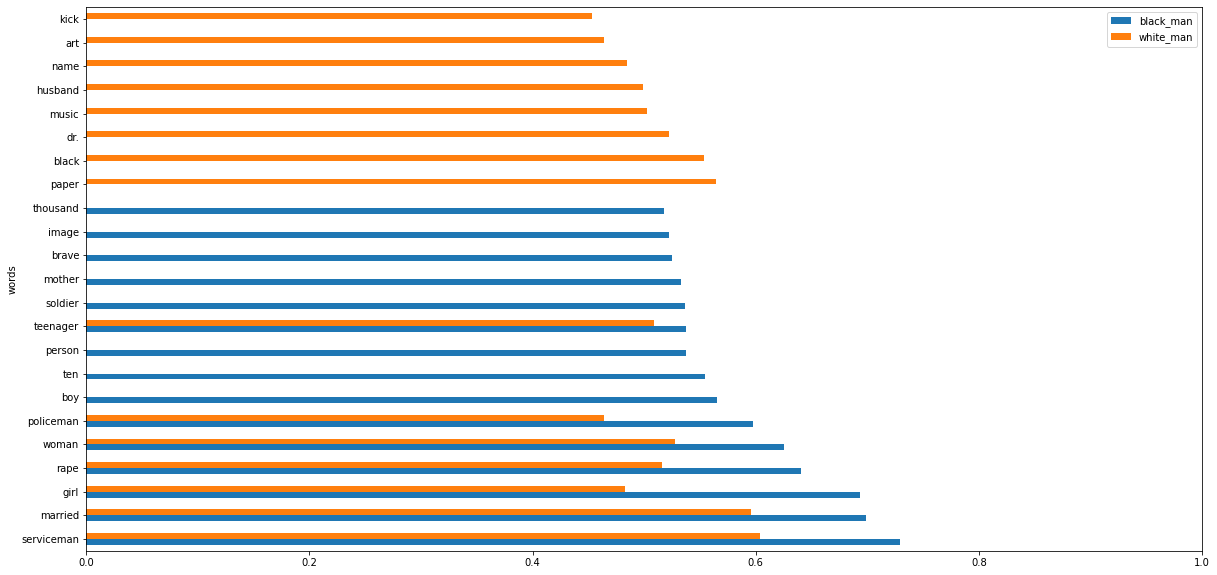

In [ ]:
Combined_plot = Combined_dfs.plot.barh(x='words', figsize=(20,10))
Combined_plot.set_xlim(0,1)

Combined_plot.set_ylabel('words')